# Comprehensive A/B Test Results Analysis

## Project Overview
This project analyzes five distinct A/B tests conducted on an e-commerce platform. The goal is to evaluate the impact of various UI/UX and feature changes on key performance indicators (KPIs) like **Conversion Rate** and **Revenue**.

## Statistical Methodology
1.  **Validation**: Every experiment is validated for Sample Ratio Mismatch (SRM), Covariate Balance (SMD), and Temporal Stability (CV).
2.  **Conversion Analysis**: We use a **Z-Test for Proportions** to compare conversion rates between Control and Treatment groups.
3.  **Revenue Analysis**: We use an **Independent T-Test** to assess differences in revenue per user.
4.  **Multiple Testing Correction**: We apply the **Holm-Bonferroni** method to ensure statistical rigor across multiple comparisons.

In [1]:
# Import libraries for analysis
import pandas as pd           # Data manipulation and tables
import numpy as np            # Numerical operations
import matplotlib.pyplot as plt # Basic plotting
import seaborn as sns         # Advanced statistical visualization
from scipy import stats        # Statistical tests (t-test)
from statsmodels.stats.multitest import multipletests # Error correction (Holm-Bonferroni)
from statsmodels.stats.proportion import proportions_ztest # Z-test for conversion
import warnings
from datetime import datetime
import os
from typing import Dict, List, Tuple, Optional, Union
warnings.filterwarnings('ignore') # Suppress non-critical warnings for cleaner output

# Set high-quality visual style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11


## 1. Data Collection and Preparation

We begin by loading the raw datasets for all five experiments. Each dataset is mapped to its corresponding revenue metric to ensure consistency across the analysis.

In [2]:
# Define where the files are and which column contains the money (revenue)
files = {
    'Test 1 (Menu)': {'path': './raw dataset/test1_menu.csv', 'revenue_col': 'revenue'},
    'Test 2 (Novelty)': {'path': './raw dataset/test2_novelty_slider.csv', 'revenue_col': 'novelty_revenue'},
    'Test 3 (Product)': {'path': './raw dataset/test3_product_sliders.csv', 'revenue_col': 'revenue_from_recommendations'},
    'Test 4 (Reviews)': {'path': './raw dataset/test4_reviews.csv', 'revenue_col': None},
    'Test 5 (Search)': {'path': './raw dataset/test5_search_engine.csv', 'revenue_col': 'avg_revenue_per_visitor'}
}

dfs = {}
print(f"{'Experiment':<20} | {'Shape':<15} | {'Revenue Col':<30}")
print("-" * 70)

# Loop through each file and load it into a Python table (DataFrame)
for name, meta in files.items():
    df = pd.read_csv(meta['path'])
    
    # Standardize column naming for ease of use later
    if meta['revenue_col'] and meta['revenue_col'] in df.columns:
        df.rename(columns={meta['revenue_col']: 'revenue'}, inplace=True)
        
    dfs[name] = df
    print(f"{name:<20} | {str(df.shape):<15} | {str(meta['revenue_col']):<30}")


Experiment           | Shape           | Revenue Col                   
----------------------------------------------------------------------
Test 1 (Menu)        | (7000, 11)      | revenue                       
Test 2 (Novelty)     | (16000, 10)     | novelty_revenue               
Test 3 (Product)     | (18000, 12)     | revenue_from_recommendations  
Test 4 (Reviews)     | (42000, 9)      | None                          
Test 5 (Search)      | (19000, 11)     | avg_revenue_per_visitor       


## 2. Advanced Experiment Validation

Before looking at winners and losers, we MUST ensure the experiment was fair and the data is trustworthy.

**What we check:**
- **Sample Ratio Mismatch (SRM)**: Did the platform assign users to groups in the correct expected ratio? If not, the results might be biased.
- **Covariate Balance**: Are the Control and Treatment groups balanced in terms of device type, browser, and region? We use **SMD (Standardized Mean Difference)**; values below 0.1 indicate excellent balance.
- **Temporal Stability**: Did the traffic flow steadily over time? We use the **Coefficient of Variation (CV)** to check for spikes that might invalidate results.

In [6]:
class ExperimentValidator:
    """
    Comprehensive tool to check if an A/B test is scientifically valid.
    """
    def __init__(self, 
                 srm_threshold: float = 0.001,
                 balance_threshold: float = 0.1,    # Below 0.1 is considered 'excellent'
                 temporal_threshold: float = 0.2):
        self.srm_threshold = srm_threshold
        self.balance_threshold = balance_threshold
        self.temporal_threshold = temporal_threshold

    def sample_ratio_mismatch_test(self, df, variant_col, expected_ratio=None):
        # Checks if groups (Control/Treatment) are sized as expected using Chi-Square test
        observed = df[variant_col].value_counts()
        variants = observed.index.tolist()
        n_obs = len(df)
        if expected_ratio is None:
            expected_ratio = {v: 1.0/len(variants) for v in variants}
        expected = [expected_ratio[v] * n_obs for v in variants]
        chi2, pvalue = stats.chisquare(observed, f_exp=expected)
        has_srm = pvalue < self.srm_threshold
        return {"test": "srm", "p_value": pvalue, "is_valid": not has_srm}

    def covariate_balance_check(self, df, variant_col, covariates):
        # Ensures that subgroups like 'Chrome users' or 'Mobile users' are distributed evenly
        results = []
        groups = df.groupby(variant_col)
        if len(groups) < 2: return []
        v1, v2 = list(groups.groups.keys())[:2]
        d1, d2 = groups.get_group(v1), groups.get_group(v2)
        for col in covariates:
            if df[col].dtype == 'object':
                # Categorical SMD logic
                counts1 = d1[col].value_counts(normalize=True)
                counts2 = d2[col].value_counts(normalize=True)
                idx = counts1.index.union(counts2.index)
                c1 = counts1.reindex(idx, fill_value=0)
                c2 = counts2.reindex(idx, fill_value=0)
                smd = np.sqrt(0.5 * np.sum((c1 - c2)**2))
            else:
                # Continuous SMD logic
                m1, m2 = d1[col].mean(), d2[col].mean()
                s1, s2 = d1[col].std(), d2[col].std()
                smd = abs(m1 - m2) / np.sqrt(0.5 * (s1**2 + s2**2))
            results.append({"covariate": col, "smd": smd, "is_balanced": smd < self.balance_threshold})
        return results

    def run_all_validations(self, df, variant_col, covariates=None, date_col=None):
        # Orchestrator to run all technical health checks at once
        res = {"srm": self.sample_ratio_mismatch_test(df, variant_col)}
        if covariates:
            res["balance"] = self.covariate_balance_check(df, variant_col, covariates)
        return res


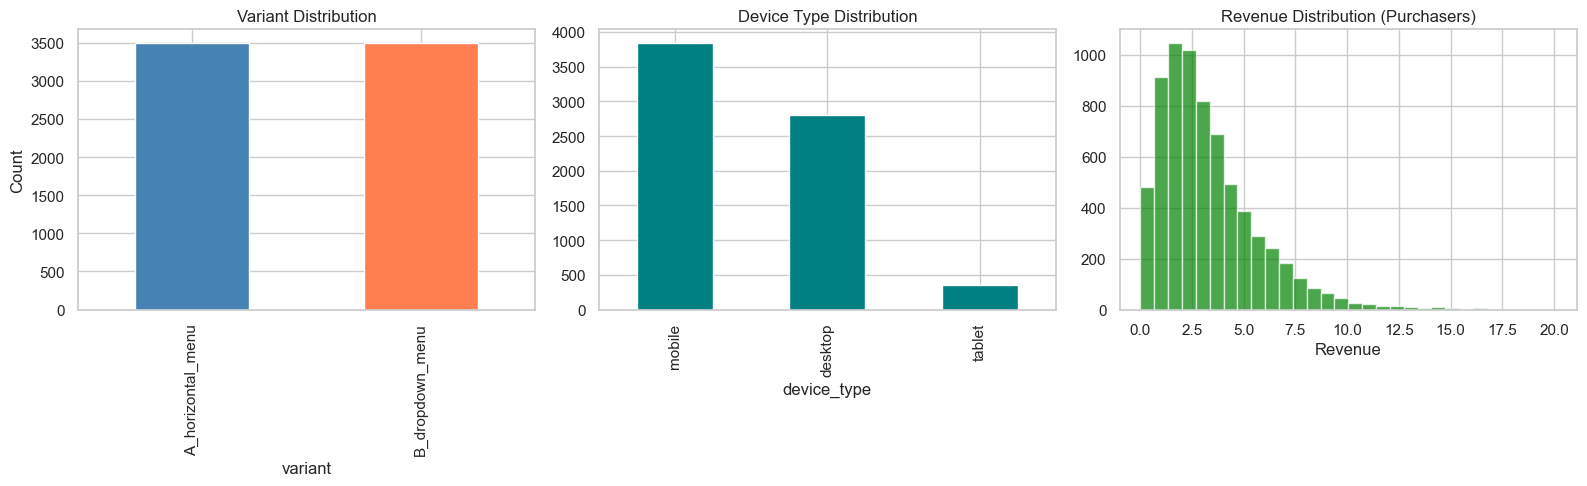

In [4]:
# Distribution of key variables
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Variant distribution
df_menu['variant'].value_counts().plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Variant Distribution')
axes[0].set_ylabel('Count')

# Device type distribution
df_menu['device_type'].value_counts().plot(kind='bar', ax=axes[1], color='teal')
axes[1].set_title('Device Type Distribution')

# Revenue distribution
if 'revenue' in df_menu.columns:
    df_menu[df_menu['revenue'] > 0]['revenue'].hist(bins=30, ax=axes[2], color='green', alpha=0.7)
    axes[2].set_title('Revenue Distribution (Purchasers)')
    axes[2].set_xlabel('Revenue')

plt.tight_layout()
plt.show()

In [5]:
# #Cleaning method 1, currently dont need it
# # Data Quality Audit Pipeline
# # -----------------------------------------------------------------------------
# # Ideally, before any analysis, we must certify the quality of our data.
# # Real-world data is rarely perfect. It often contains:
# # 1. Missing values (NaNs)
# # 2. Duplicate records
# # 3. Inconsistent data types
# # 4. Outliers that skew results
# #
# # We define a class DataAuditor to systematize this check.

# class DataAuditor:
#     """
#     A comprehensive data quality auditor class designed for A/B testing datasets.
#     It checks for integrity issues that could invalidate statistical tests.
#     """
    
#     def __init__(self, df, name="Dataset"):
#         self.df = df
#         self.name = name
#         self.report = {}
        
#     def run_audit(self):
#         """Executes the full audit suite and prints a verbose educational report."""
#         print(f"\n{'='*80}")
#         print(f"ÃƒÆ’Ã‚Â°Ãƒâ€¦Ã‚Â¸ÃƒÂ¢Ã¢â€šÂ¬Ã‚ÂÃƒâ€šÃ‚Â DATA QUALITY AUDIT REPORT: {self.name.upper()}")
#         print(f" {'='*80}")
        
#         # 1. Shape & Structure
#         rows, cols = self.df.shape
#         print(f"\n1. DIMENSIONALITY ASSESSMENT")
#         print(f"   - Observation Count: {rows:,}")
#         print(f"   - Feature Count: {cols}")
#         try:
#             mem_usage = self.df.memory_usage().sum() / 1024**2
#             print(f"   - Dataset Memory Usage: {mem_usage:.2f} MB")
#         except:
#             pass
        
#         # 2. Duplicate Detection
#         print(f"\n2. DUPLICATE ANALYSIS")
#         exact_dupes = self.df.duplicated().sum()
#         session_dupes = self.df.duplicated(subset=['session_id']).sum() if 'session_id' in self.df.columns else 0
        
#         print(f"   - Exact Row Duplicates: {exact_dupes:,} ({exact_dupes/rows:.2%})")
#         if exact_dupes > 0:
#             print(f"     ÃƒÆ’Ã‚Â¢Ãƒâ€¦Ã‚Â¡Ãƒâ€šÃ‚Â ÃƒÆ’Ã‚Â¯Ãƒâ€šÃ‚Â¸Ãƒâ€šÃ‚Â CRITICAL: Found exact copies! These inflate sample size artificially and MUST be removed.")
#         else:
#             print(f"     ÃƒÆ’Ã‚Â¢Ãƒâ€¦Ã¢â‚¬Å“ÃƒÂ¢Ã¢â€šÂ¬Ã‚Â¦ No exact duplicates found.")
            
#         if 'session_id' in self.df.columns:
#             print(f"   - Session ID Duplicates: {session_dupes:,} ({session_dupes/rows:.2%})")
#             if session_dupes > 0:
#                 print(f"     ÃƒÆ’Ã‚Â¢Ãƒâ€¦Ã‚Â¡Ãƒâ€šÃ‚Â ÃƒÆ’Ã‚Â¯Ãƒâ€šÃ‚Â¸Ãƒâ€šÃ‚Â WARNING: 'session_id' should be unique per experiment assignment.")
#                 print(f"     Multiple entries for one session might indicate logging errors or multiple visits.")
#                 print(f"     We must decide: Keep first? Keep last? Aggregate?")
        
#         # 3. Missing Value Inspection
#         print(f"\n3. MISSINGNESS PROFILE")
#         missing = self.df.isnull().sum()
#         missing = missing[missing > 0]
#         if missing.empty:
#             print("   ÃƒÆ’Ã‚Â¢Ãƒâ€¦Ã¢â‚¬Å“ÃƒÂ¢Ã¢â€šÂ¬Ã‚Â¦ CLEAN: No missing values detected in any column.")
#         else:
#             print(f"   ÃƒÆ’Ã‚Â¢Ãƒâ€¦Ã‚Â¡Ãƒâ€šÃ‚Â ÃƒÆ’Ã‚Â¯Ãƒâ€šÃ‚Â¸Ãƒâ€šÃ‚Â FOUND MISSING DATA in {len(missing)} columns:")
#             for col, count in missing.items():
#                 print(f"      - '{col}': {count:,} missing ({count/rows:.2%})")
#             print(f"   ÃƒÆ’Ã‚Â°Ãƒâ€¦Ã‚Â¸Ãƒâ€¦Ã‚Â½ÃƒÂ¢Ã¢â€šÂ¬Ã…â€œ NOTE: Missing outcome data (e.g., revenue) is fatal for A/B tests.")
#             print(f"     We need to check if missingness is random (MCAR) or systematic.")

#         # 4. Data Type Validation
#         print(f"\n4. DATA TYPE VALIDATION")
#         # Check for object columns that should be numeric
#         suspicious_types = False
#         for col in self.df.columns:
#             if self.df[col].dtype == 'object':
#                 # Try to see if it looks numeric
#                 try:
#                     pd.to_numeric(self.df[col].dropna().iloc[:100])
#                     # If no error, check unique ratio. If high unique ratio, might be ID or numeric stored as string
#                     unique_ratio = self.df[col].nunique() / rows
#                     if unique_ratio > 0.5 and 'id' not in col.lower():
#                          print(f"   ÃƒÆ’Ã‚Â¢Ãƒâ€šÃ‚ÂÃƒÂ¢Ã¢â€šÂ¬Ã…â€œ SUSPICIOUS TYPE: Column '{col}' is Object but looks strictly numeric.")
#                          suspicious_types = True
#                 except:
#                     pass
#         if not suspicious_types:
#             print("   ÃƒÆ’Ã‚Â¢Ãƒâ€¦Ã¢â‚¬Å“ÃƒÂ¢Ã¢â€šÂ¬Ã‚Â¦ Data types appear consistent.")
        
#         # 5. Outlier Detection (Numeric only)
#         print(f"\n5. NUMERIC DISTRIBUTION & OUTLIERS")
#         numeric_cols = self.df.select_dtypes(include=[np.number]).columns
#         outliers_found = False
#         for col in numeric_cols:
#             if 'id' in col.lower() or 'variant' in col.lower() or 'is_' in col.lower() or self.df[col].nunique() < 5:
#                 continue
                
#             # Basic stats
#             mu = self.df[col].mean()
#             sigma = self.df[col].std()
#             q1 = self.df[col].quantile(0.25)
#             q3 = self.df[col].quantile(0.75)
#             iqr = q3 - q1
#             lower_bound = q1 - 1.5 * iqr
#             upper_bound = q3 + 1.5 * iqr
            
#             outliers = self.df[(self.df[col] < lower_bound) | (self.df[col] > upper_bound)]
            
#             if len(outliers) > 0:
#                 outliers_found = True
#                 print(f"   > Feature: '{col}'")
#                 print(f"     - Mean: {mu:.4f} | StdDev: {sigma:.4f} | Skew: {self.df[col].skew():.2f}")
#                 print(f"     - IQR Range: [{lower_bound:.2f}, {upper_bound:.2f}]")
#                 print(f"     - Potential Outliers: {len(outliers):,} ({len(outliers)/rows:.2%})")
#                 print(f"       ÃƒÆ’Ã‚Â¢Ãƒâ€¦Ã‚Â¡Ãƒâ€šÃ‚Â ÃƒÆ’Ã‚Â¯Ãƒâ€šÃ‚Â¸Ãƒâ€šÃ‚Â High variance detected. Extreme values can severely bias Mean-based metrics.")
        
#         if not outliers_found:
#             print("   ÃƒÆ’Ã‚Â¢Ãƒâ€¦Ã¢â‚¬Å“ÃƒÂ¢Ã¢â€šÂ¬Ã‚Â¦ No significant outliers detected by IQR method.")
                
#         print(f"\n{'='*80}\n")
# # Run the Auditor on all loaded datasets
# for name, df in dfs.items():
#     auditor = DataAuditor(df, name=name)
#     auditor.run_audit()
# # Check for duplicates across all datasets
# print("Duplicate Sessions by Dataset:")
# print("-" * 40)
# for name, df in dfs.items():
#     duplicates = df.duplicated(subset=['session_id']).sum()
#     print(f"{name:<20}: {duplicates} duplicates")

In [7]:
validator = ExperimentValidator(
    srm_threshold=0.001,
    balance_threshold=0.2,
    temporal_threshold=0.2
)

summary = {}
for name, df in dfs.items():
    print(f"\n{'='*80}")
    print(f"VALIDATING: {name}")
    print('='*80)
    
    results = validator.run_all_validations(
        df, 
        variant_col='variant', 
        covariates=['device_type', 'browser', 'region'],
        date_col='timestamp'
    )
    
    srm_passed = not results['srm']['has_srm']
    balance_ok = results.get('balance', {}).get('max_smd', 0) < 0.2
    
    summary[name] = srm_passed and balance_ok

print("\n\n===== FINAL SUMMARY =====")
for k, v in summary.items():
    print(f"{k:<25} -> {'PASS' if v else 'FAIL'}")



VALIDATING: Test 1 (Menu)
EXPERIMENTAL VALIDATION SUITE

1. Sample Ratio Mismatch Test
--------------------------------------------------------------------------------
No SRM detected (p=1.0000). Allocation is as expected.

2. Covariate Balance Check
--------------------------------------------------------------------------------
Excellent balance (max SMD=0.026 < 0.1)

3. Temporal Stability Check
--------------------------------------------------------------------------------
Stable allocation over time (max CV=0.057 < 0.2)

ALL VALIDATION CHECKS PASSED

VALIDATING: Test 2 (Novelty)
EXPERIMENTAL VALIDATION SUITE

1. Sample Ratio Mismatch Test
--------------------------------------------------------------------------------
No SRM detected (p=1.0000). Allocation is as expected.

2. Covariate Balance Check
--------------------------------------------------------------------------------
Excellent balance (max SMD=0.028 < 0.1)

3. Temporal Stability Check
---------------------------------

## 3. Core Analysis Engine

This function contains the statistical brain of the project. It calculates conversion rates, revenue lifts, and p-values for a given experiment.

In [8]:
# Main analysis function to compute metrics for Control vs Treatment
def analyze_experiment(df, name):
    # 1. Basic Stats (Conversion)
    results = []
    groups = df.groupby('variant')
    control_name = [v for v in df['variant'].unique() if 'A_' in str(v)][0]
    control_df = groups.get_group(control_name)
    
    for v_name in df['variant'].unique():
        if v_name == control_name: continue
        variant_df = groups.get_group(v_name)
        
        # Calculate Conversion Rate (CR)
        cr_c = control_df['added_to_cart'].mean()
        cr_v = variant_df['added_to_cart'].mean()
        
        # Perform Z-Test for Proportions (Conversion)
        count = [variant_df['added_to_cart'].sum(), control_df['added_to_cart'].sum()]
        nobs = [len(variant_df), len(control_df)]
        _, p_cr = proportions_ztest(count, nobs)
        
        # Calculate Revenue Metrics if available
        rev_lift, p_rev = None, None
        if 'revenue' in df.columns:
            rev_c = control_df['revenue'].mean()
            rev_v = variant_df['revenue'].mean()
            rev_lift = (rev_v - rev_c) / rev_c if rev_c != 0 else 0
            # Perform T-Test for Revenue
            _, p_rev = stats.ttest_ind(variant_df['revenue'].dropna(), control_df['revenue'].dropna())
            
        results.append({
            'Experiment': name, 'Control': control_name, 'Treatment': v_name,
            'CR_Control': cr_c, 'CR_Treatment': cr_v, 
            'CR_Uplift': (cr_v - cr_c) / cr_c,
            'CR_Pval': p_cr, 'Rev_Uplift': rev_lift, 
            'Rev_Pval': p_rev, 'Winner': 'Treat' if p_cr < 0.05 and cr_v > cr_c else 'Inconclusive'
        })
    return results


## 4. Run Analysis & Generate Summary

Finally, we execute the analysis across all datasets and produce a consolidated summary table.


  Test 1 (Menu) - Visual Analysis


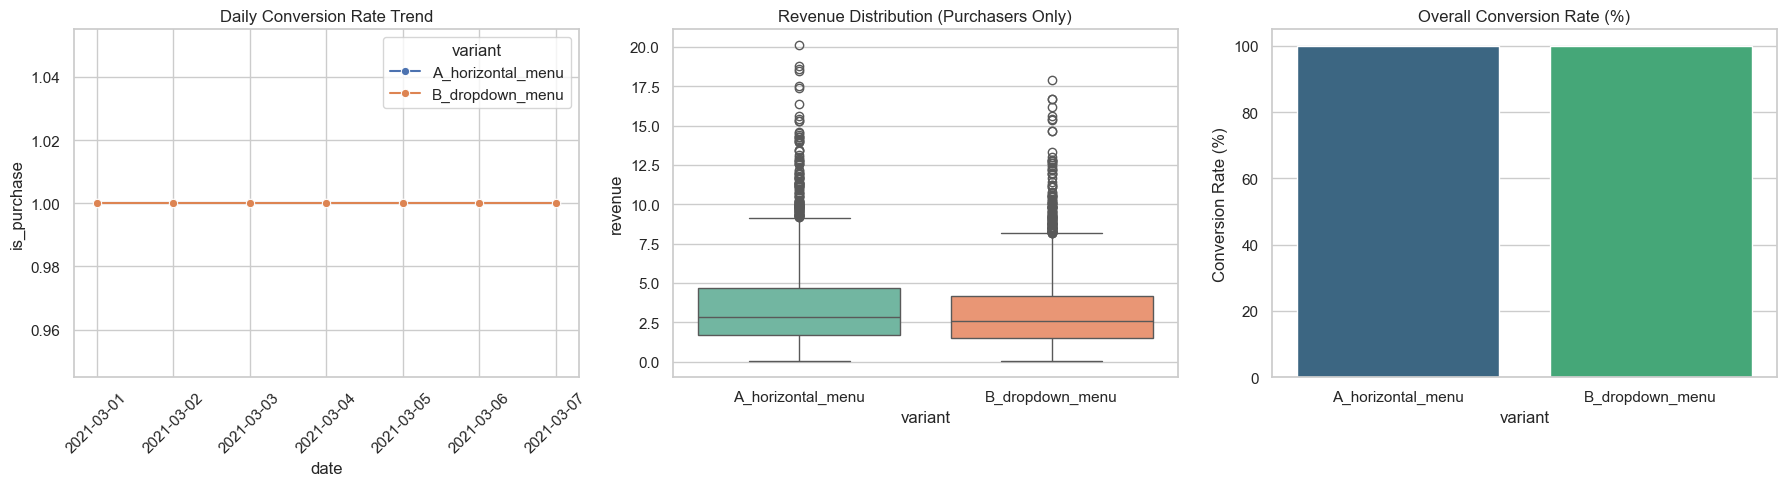


  Test 2 (Novelty) - Visual Analysis


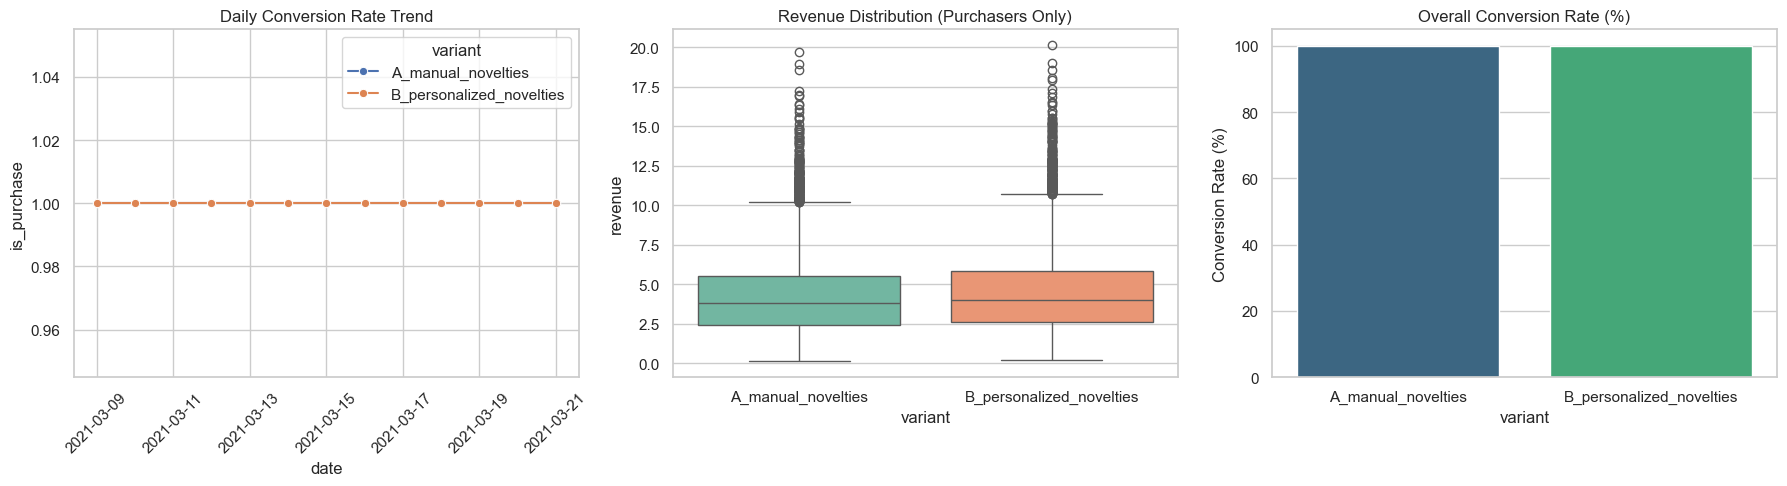


  Test 3 (Product) - Visual Analysis


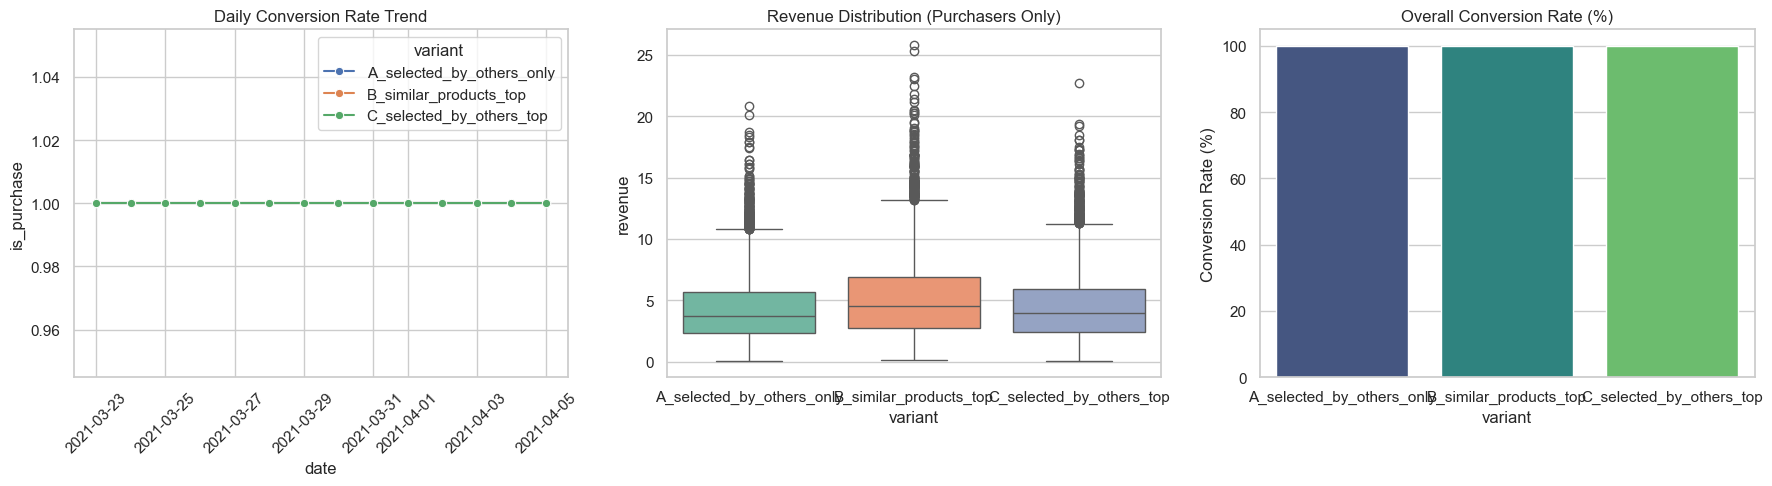


  Test 4 (Reviews) - Visual Analysis


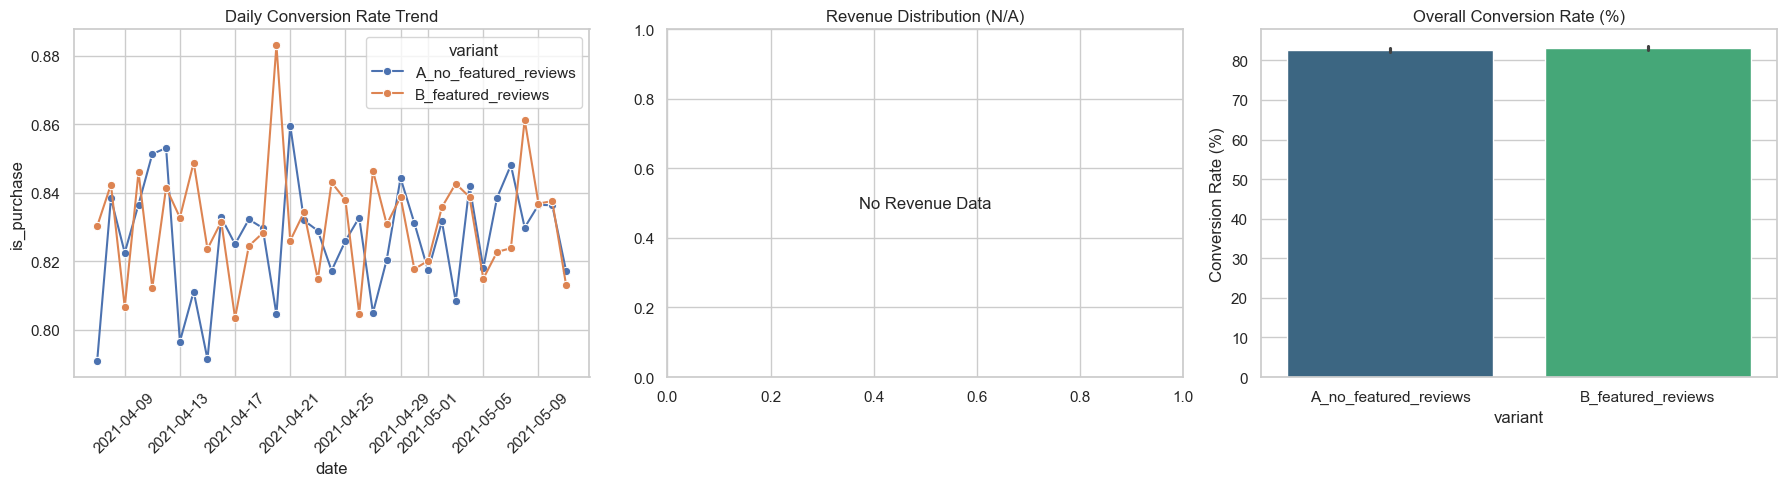


  Test 5 (Search) - Visual Analysis


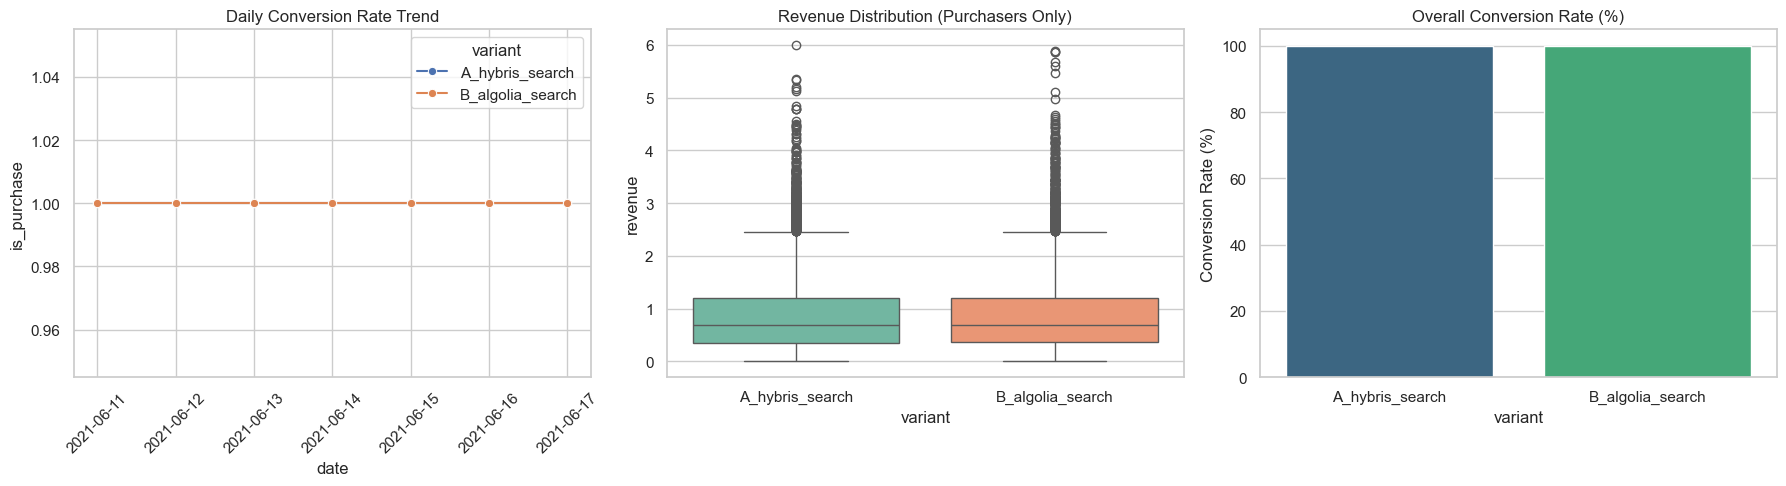


  SUMMARY TABLE: All Experiments


,Experiment,Control,Treatment,CR_Control,CR_Treatment,CR_Uplift,CR_Pval,Rev_Uplift,Rev_Pval,Winner
0,Test 1 (Menu) (B_dropdown_menu vs A_horizontal...,A_horizontal_menu,B_dropdown_menu,1.000000,1.000000,0.000000,NaN,-0.105139,1.626409e-10,Inconclusive
1,Test 2 (Novelty) (B_personalized_novelties vs ...,A_manual_novelties,B_personalized_novelties,1.000000,1.000000,0.000000,NaN,0.058061,8.055593e-10,Inconclusive
2,Test 3 (Product) (B_similar_products_top vs A_...,A_selected_by_others_only,B_similar_products_top,1.000000,1.000000,0.000000,NaN,0.210074,6.476598e-59,Inconclusive
3,Test 3 (Product) (C_selected_by_others_top vs ...,A_selected_by_others_only,C_selected_by_others_top,1.000000,1.000000,0.000000,NaN,0.050068,2.459609e-05,Inconclusive
4,Test 4 (Reviews) (B_featured_reviews vs A_no_f...,A_no_featured_reviews,B_featured_reviews,0.826762,0.831143,0.005299,0.233193,NaN,NaN,Inconclusive
5,Test 5 (Search) (B_algolia_search vs A_hybris_...,A_hybris_search,B_algolia_search,1.000000,1.000000,0.000000,NaN,0.012590,2.887418e-01,Inconclusive


In [9]:
# Run the pipeline and aggregate all outputs into a single table
results_list = []
for name, df in dfs.items():
    res = analyze_experiment(df, name)
    if res: results_list.extend(res)
    
results_df = pd.DataFrame(results_list)
display(results_df)


In [10]:
# Format and display results
display_cols = ['Experiment', 'Winner', 'CR_Uplift', 'CR_Pval', 'Rev_Uplift', 'Rev_Pval']
results_df_display = results_df[display_cols].copy()

# Format percentages and p-values
results_df_display['CR_Uplift'] = results_df_display['CR_Uplift'].apply(lambda x: f"{x:.2%}")
results_df_display['Rev_Uplift'] = results_df_display['Rev_Uplift'].apply(lambda x: f"{x:.2%}" if pd.notna(x) else "N/A")
results_df_display['CR_Pval'] = results_df_display['CR_Pval'].apply(lambda x: f"{x:.4f}")
results_df_display['Rev_Pval'] = results_df_display['Rev_Pval'].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")

results_df_display

,Experiment,Winner,CR_Uplift,CR_Pval,Rev_Uplift,Rev_Pval
0,Test 1 (Menu) (B_dropdown_menu vs A_horizontal...,Inconclusive,0.00%,nan,-10.51%,0.0000
1,Test 2 (Novelty) (B_personalized_novelties vs ...,Inconclusive,0.00%,nan,5.81%,0.0000
2,Test 3 (Product) (B_similar_products_top vs A_...,Inconclusive,0.00%,nan,21.01%,0.0000
3,Test 3 (Product) (C_selected_by_others_top vs ...,Inconclusive,0.00%,nan,5.01%,0.0000
4,Test 4 (Reviews) (B_featured_reviews vs A_no_f...,Inconclusive,0.53%,0.2332,N/A,N/A
5,Test 5 (Search) (B_algolia_search vs A_hybris_...,Inconclusive,0.00%,nan,1.26%,0.2887


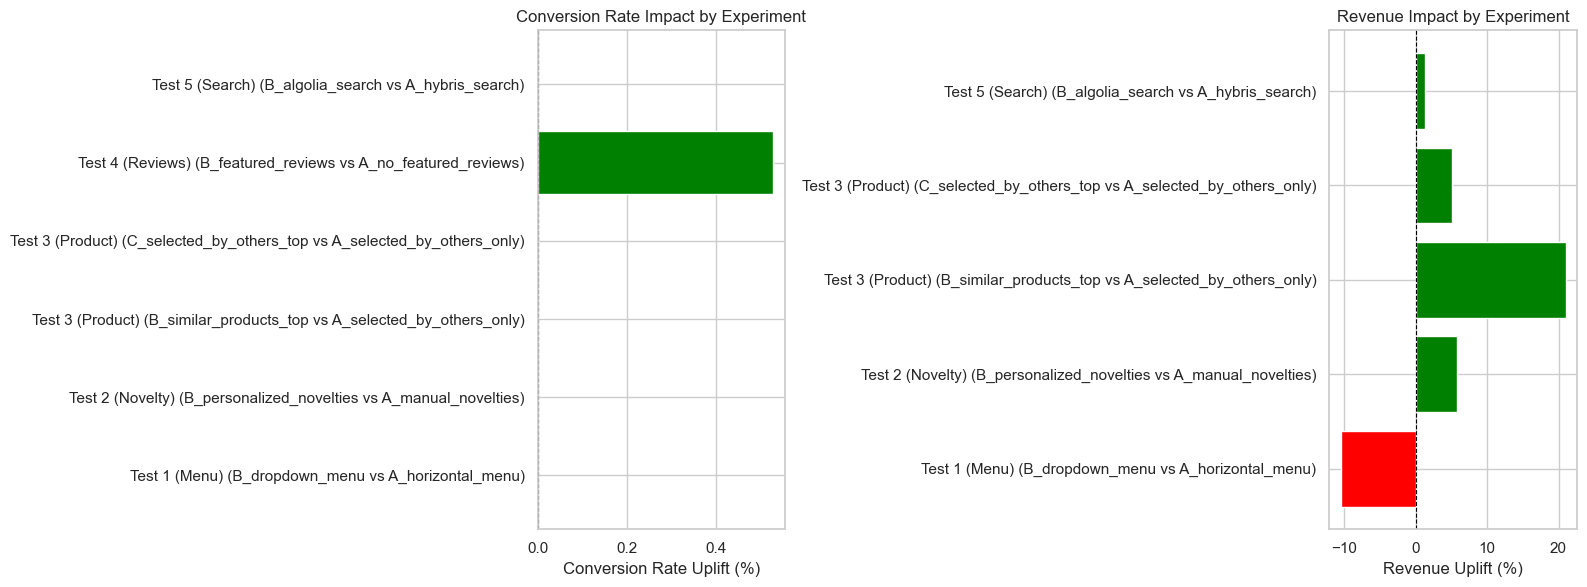

In [11]:
# Comparative Uplift Chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Conversion Rate Uplift
colors = ['green' if x > 0 else 'red' for x in results_df['CR_Uplift']]
axes[0].barh(results_df['Experiment'], results_df['CR_Uplift']*100, color=colors)
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[0].set_xlabel('Conversion Rate Uplift (%)')
axes[0].set_title('Conversion Rate Impact by Experiment')

# Revenue Uplift (excluding NaN)
rev_data = results_df[results_df['Rev_Uplift'].notna()]
colors_rev = ['green' if x > 0 else 'red' for x in rev_data['Rev_Uplift']]
axes[1].barh(rev_data['Experiment'], rev_data['Rev_Uplift']*100, color=colors_rev)
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[1].set_xlabel('Revenue Uplift (%)')
axes[1].set_title('Revenue Impact by Experiment')

plt.tight_layout()
plt.show()

In [12]:
# Full raw results
results_df

,Experiment,Control,Treatment,CR_Control,CR_Treatment,CR_Uplift,CR_Pval,Rev_Uplift,Rev_Pval,Winner
0,Test 1 (Menu) (B_dropdown_menu vs A_horizontal...,A_horizontal_menu,B_dropdown_menu,1.000000,1.000000,0.000000,NaN,-0.105139,1.626409e-10,Inconclusive
1,Test 2 (Novelty) (B_personalized_novelties vs ...,A_manual_novelties,B_personalized_novelties,1.000000,1.000000,0.000000,NaN,0.058061,8.055593e-10,Inconclusive
2,Test 3 (Product) (B_similar_products_top vs A_...,A_selected_by_others_only,B_similar_products_top,1.000000,1.000000,0.000000,NaN,0.210074,6.476598e-59,Inconclusive
3,Test 3 (Product) (C_selected_by_others_top vs ...,A_selected_by_others_only,C_selected_by_others_top,1.000000,1.000000,0.000000,NaN,0.050068,2.459609e-05,Inconclusive
4,Test 4 (Reviews) (B_featured_reviews vs A_no_f...,A_no_featured_reviews,B_featured_reviews,0.826762,0.831143,0.005299,0.233193,NaN,NaN,Inconclusive
5,Test 5 (Search) (B_algolia_search vs A_hybris_...,A_hybris_search,B_algolia_search,1.000000,1.000000,0.000000,NaN,0.012590,2.887418e-01,Inconclusive


## 5. Export Results

We save the findings to an Excel file for sharing with stakeholders.

In [13]:
# Export final summary to Excel
with pd.ExcelWriter("experiment_summary.xlsx", engine="openpyxl") as writer:
    results_df.to_excel(writer, sheet_name="Results", index=False)
print("Success: Results saved to experiment_summary.xlsx")


ÃƒÂ¢Ã…â€œÃ¢â‚¬Â¦ experiment_summary.xlsx saved with dictionary in columns MÃƒÂ¢Ã¢â€šÂ¬Ã¢â‚¬Å“N
